In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from data_columns import *
import brate_trainer_rf_xgb
import importlib
brate_trainer_rf_xgb = importlib.reload(brate_trainer_rf_xgb)
from brate_trainer_rf_xgb import train_rf_xgb
from brate_trainer_rf_xgb import find_baseline

In [3]:
# To run RF and XGB over many parameter settings
# These are the deafult set
PARAMETERS = {
         'model_save_num': 200001,
         'output_file_name': 'test_modFeat3_model_parameters_results_wind_size.csv',
         'aggr_wind_size': '12', # ['4', '8', '12', '16']
         'horz_wind_size': '2', # ['2', '4', '6']
         'pred_var': 'brate', # options ['brate', 'nseg']
         'model_type': 'rf', # options ['rf', 'xgb'] 
         'remove_ran_features': False,
         'remove_dash_features': False,
         'remove_prev_brate_val': False,
         #------------------
         'n_trees': 350,
         'tree_depth': 25,
         'min_samples_leaf': 2,
         'tree_depth_list': [25, 35, 50],
         'min_samples_leaf_list': [1, 5, 10],
          #----------------
         'train_size': 0,
         'test_size': 0,
         'runtime': 0,
         'accuracy': 0,
         'roc_auc': 0,
         'f1score': 0
        }
tune_hyperparam = False

START
2 12
acc, roc_auc, f1score:  0.896847842854939 0.9913091564303725 0.8907512802643813
[[0.87552059 0.0740398  0.0180472  0.02915317 0.00277649 0.00046275]
 [0.08587944 0.81626755 0.07473163 0.01279934 0.0090834  0.00123865]
 [0.01331361 0.06841716 0.82914201 0.08542899 0.00295858 0.00073964]
 [0.00287632 0.00172579 0.03662512 0.91888782 0.03950144 0.00038351]
 [0.00019755 0.0003951  0.         0.04938759 0.93500593 0.01501383]
 [0.         0.         0.         0.         0.04142326 0.95857674]]


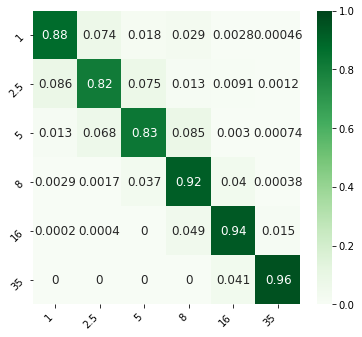

END


In [4]:
parameters = PARAMETERS.copy()
feature_comb = [[False, False, False]]#, # all metrics
                #[True, False, False], # remove RAN metrics
                #[False, False, True]] # remove last segment history
                
model_types = ['rf']#, 'xgb']
aggr_wind_size = ['12']# ['4','8','12','16','20','24']
horz_wind_size = ['2']
print('START')
for hw in horz_wind_size:
    for aw in aggr_wind_size:
        train_data_dir = '../data/data_train/dataset7-' \
                                    + hw + 'sWsize-' \
                                    + aw + 'aggsize/'
        print(hw, aw)
        for model_type in model_types:
            n = PARAMETERS['model_save_num']
            for feats in feature_comb:
                parameters['remove_ran_features'] = feats[0]
                parameters['remove_dash_features']= feats[1]
                parameters['remove_prev_brate_val']= feats[2]
                parameters['pred_var'] = 'brate'
                parameters['model_type'] = model_type
                parameters['model_save_num'] = n
                parameters['aggr_wind_size'] = aw
                parameters['horz_wind_size'] = hw
                model_save_path = '../models/'+ parameters['model_type']+'/model' + str(parameters['model_save_num']) + '/'  
                n = n+1
                train_rf_xgb(parameters, train_data_dir, model_save_path, tune_hyperparam)  
print('END')

In [ ]:
# only last seg brate: 0.7111290601742342 0.8800698744549159 0.6838103076670311
#+1 0.6922633127560145 0.9066570564622012 0.6588707747271011
#+2 0.7283793919113829 0.9254896243457208 0.7000134200289029
#+3 0.7618415738764207 0.9450974820741336 0.737456466366819
#+4 0.8232273697571107 0.9622976496925079 0.7976109059411209
# from the dash+ran-last set 
#'mean-ThPutOverLastSeg_bps': 0.6153002942364276 0.861454818049792 0.5645359987425221
#2 0.6624935094905672 0.8957682826406911 0.6230655519536468
#3 0.6945133560260774 0.9190926009545007 0.6619332842225848
#4 0.8096117233023712 0.957278253635582 0.7835599718874547
#5 0.8288236312236774 0.962592455004251 0.803817207013997
#6 0.8315352218311891 0.966467258701123 0.8076255105582515

In [26]:
# find the baseline
parameters = PARAMETERS.copy()
train_data_dir = '../data/data_train/modFeat3_dataset7-' \
                                + '2' + 'sWsize-' \
                                + '16' + 'aggsize/'
find_baseline(PARAMETERS, train_data_dir)

Reading datset from:  ../data/data_train/modFeat3_dataset7-2sWsize-16aggsize/
Baseline
accuracy 0.699490924049982 f1score 0.6831886943999231


## 

In [ ]:
# Do this with raw data over all runs
raw_data_path = "/home/shared_data/dash/raw_data/dataset7_35Mbps_max_brate_withCa/"
num_samples = 0
num_changes = 0
for r in os.listdir(raw_data_path):
    df_client_log = ld.load_dash_client_log(raw_data_path+r+"/dash_client_log.txt", 
                                        verbose=False)
    dash_client_node_ids = df_client_log['Node'].unique()
    for ue in dash_client_node_ids:
        df_client_log_per_node = df_client_log[df_client_log['Node'] == ue]
        num_samples = num_samples + len(df_client_log_per_node.index)
        df_client_log_changes = df_client_log_per_node[df_client_log_per_node['newBitRate_bps'] != df_client_log_per_node['oldBitRate_bps']]
        num_changes = num_changes + len(df_client_log_changes.index)
    
persistent_prediction_bitrate_acc = 1 - (num_changes/num_samples)
print("Persistent prediction accuracy values with raw samples")
print("Bitrate: " + str(persistent_prediction_bitrate_acc))